# Data Exploration for Subword Unit Duration Modeling

This notebook explores the ASR time alignment data for native and non-native English speakers.

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path to import project modules
sys.path.insert(0, os.path.abspath('..'))

from src.data_processing import load_data, extract_phone_data, calculate_speaking_rate
from src.visualisations import (
    plot_duration_histograms,
    plot_top_phones_by_duration,
    plot_position_effects,
    plot_speaking_rate_effects
)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load the Data

In [2]:
# Define data directories
native_dir = '../data/american_english/american_english'
nonnative_dir = '../data/other_english/other_english'

# Load the data
native_data = load_data(native_dir)
nonnative_data = load_data(nonnative_dir)

print(f"Loaded {len(native_data)} native speaker utterances")
print(f"Loaded {len(nonnative_data)} non-native speaker utterances")

File ../data/american_english/american_english\anonymous-20080425-atw_a0028\result.json has non-dict 'result': <class 'str'>
File ../data/american_english/american_english\anonymous-20080702-oqm_a0387\result.json has non-dict 'result': <class 'str'>
File ../data/american_english/american_english\anonymous-20090917-vwy_b0305\result.json has non-dict 'result': <class 'str'>
File ../data/american_english/american_english\anonymous-20100515-nfo_a0217\result.json has non-dict 'result': <class 'str'>
File ../data/american_english/american_english\anonymous-20100515-nfo_a0224\result.json has non-dict 'result': <class 'str'>
File ../data/american_english/american_english\anonymous-20100820-ebd_b0103\result.json has non-dict 'result': <class 'str'>
File ../data/american_english/american_english\anonymous-20101011-qrd_a0385\result.json has non-dict 'result': <class 'str'>
File ../data/american_english/american_english\anonymous-20111004-fxb_b0014\result.json has non-dict 'result': <class 'str'>


Loaded 28417 native speaker utterances
Loaded 4736 non-native speaker utterances


## 2. Examine JSON Structure

In [3]:
# Examine structure of the first result utterance
utterance = native_data[0]["result"]

print("Keys in utterance:")
print(list(utterance.keys()))

print("\nUtterance text:")
print(utterance.get('text_normalized', ''))


Keys in utterance:
['asr_info', 'language', 'text', 'text_normalized', 'segments', 'ppl']

Utterance text:
ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NEVER COULD MAKE UP HIS MIND


In [4]:
utterance = native_data[0]["result"]

segments = utterance.get("segments", [])
print("Utterance text:")
print(utterance.get("text_normalized", ''))

if segments:
    first_segment_words = segments[0].get("words", [])
    print("Number of words in first segment:", len(first_segment_words))
else:
    print("No segments found.")

Utterance text:
ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NEVER COULD MAKE UP HIS MIND
Number of words in first segment: 17


In [5]:
segments = native_data[0]["result"]["segments"]

print(f"Number of segments: {len(segments)}\n")
print("Sample segment keys:", segments[0].keys())
print("Sample segment:", segments[0])


Number of segments: 1

Sample segment keys: dict_keys(['text', 'text_normalized', 'start', 'duration', 'temperature', 'avg_logprob', 'compression_ratio', 'no_speech_prob', 'words'])
Sample segment: {'text': 'Once there was a young rat named Arthur who never could make up his mind.', 'text_normalized': 'ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NEVER COULD MAKE UP HIS MIND', 'start': 0.0, 'duration': 5.1000000000000005, 'temperature': False, 'avg_logprob': -0.20595579398305794, 'compression_ratio': 1.0138888888888888, 'no_speech_prob': 0.004369630012661219, 'words': [{'word': '', 'word_normalized': 'sil', 'start': 0.0, 'duration': 1.14, 'phones': [{'phone': 'SIL', 'start': 0.0, 'duration': 1.14, 'class': 'sil'}], 'oov': False, 'probability': None}, {'word': 'Once', 'word_normalized': 'ONCE', 'start': 1.14, 'duration': 0.39, 'phones': [{'phone': 'o', 'start': 1.14, 'duration': 0.18, 'class': 'V'}, {'phone': 'n', 'start': 1.32, 'duration': 0.09, 'class': 'C'}, {'phone': 'c', 'start': 1.

In [6]:
# Navigate to the first segment and first word
utterance = native_data[0].get('result', {})
segments = utterance.get('segments', [])

if segments and segments[0].get('words'):
    first_word = segments[0]['words'][0]
    
    print("Keys in word:")
    print(list(first_word.keys()))

    print("\nWord text:")
    print(first_word.get('word_normalized', ''))

    print("\nWord start time and duration:")
    print(f"Start: {first_word.get('start', 0.0)}, Duration: {first_word.get('duration', 0.0)}")

    print("\nNumber of phones:")
    print(len(first_word.get('phones', [])))
else:
    print("No words found in the first segment.")


Keys in word:
['word', 'word_normalized', 'start', 'duration', 'phones', 'oov', 'probability']

Word text:
sil

Word start time and duration:
Start: 0.0, Duration: 1.14

Number of phones:
1


In [7]:
# Get first non-silence word
first_word = {}
for seg in segments:
    for word in seg.get('words', []):
        if word.get('word_normalized', '').lower() != 'sil':
            first_word = word
            break
    if first_word:
        break

if first_word:
    print("Keys in word:")
    print(list(first_word.keys()))

    print("\nWord text:")
    print(first_word.get('word_normalized', ''))

    print("\nWord start time and duration:")
    print(f"Start: {first_word.get('start', 0.0)}, Duration: {first_word.get('duration', 0.0)}")

    print("\nNumber of phones:")
    print(len(first_word.get('phones', [])))
else:
    print("No non-silence word found.")

Keys in word:
['word', 'word_normalized', 'start', 'duration', 'phones', 'oov', 'probability']

Word text:
ONCE

Word start time and duration:
Start: 1.14, Duration: 0.39

Number of phones:
4


## 3. Extract Phone-level Data

In [8]:
# Extract phone-level data from updated segment-based structure
native_phone_df = extract_phone_data(native_data)
nonnative_phone_df = extract_phone_data(nonnative_data)

print(f"Native speaker data: {len(native_phone_df)} phones")
print(f"Non-native speaker data: {len(nonnative_phone_df)} phones")

native_phone_df.head()


Native speaker data: 1178601 phones
Non-native speaker data: 201818 phones


,utterance_id,utterance_text,word,word_idx,word_pos_in_utterance,word_start,word_duration,phone,phone_idx,phone_pos_in_word,phone_start,phone_duration,phone_class
0,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,sil,0,0.000000,0.00,1.14,SIL,0,0.00,0.00,1.14,sil
1,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,ONCE,1,0.058824,1.14,0.39,o,0,0.00,1.14,0.18,V
2,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,ONCE,1,0.058824,1.14,0.39,n,1,0.25,1.32,0.09,C
3,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,ONCE,1,0.058824,1.14,0.39,c,2,0.50,1.41,0.09,C
4,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,ONCE,1,0.058824,1.14,0.39,e,3,0.75,1.50,0.03,V


Calculate Speaking Rate

In [9]:
native_phone_df = calculate_speaking_rate(native_phone_df)
nonnative_phone_df = calculate_speaking_rate(nonnative_phone_df)

native_phone_df.head()

,utterance_id,utterance_text,word,word_idx,word_pos_in_utterance,word_start,word_duration,phone,phone_idx,phone_pos_in_word,phone_start,phone_duration,phone_class,phone_duration_mean,phone_duration_std,speaking_rate,phone_duration_norm
0,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,sil,0,0.000000,0.00,1.14,SIL,0,0.00,0.00,1.14,sil,0.085,0.143095,11.764706,7.372708
1,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,ONCE,1,0.058824,1.14,0.39,o,0,0.00,1.14,0.18,V,0.085,0.143095,11.764706,0.663893
2,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,ONCE,1,0.058824,1.14,0.39,n,1,0.25,1.32,0.09,C,0.085,0.143095,11.764706,0.034942
3,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,ONCE,1,0.058824,1.14,0.39,c,2,0.50,1.41,0.09,C,0.085,0.143095,11.764706,0.034942
4,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,ONCE,1,0.058824,1.14,0.39,e,3,0.75,1.50,0.03,V,0.085,0.143095,11.764706,-0.384359


## 4. Basic Statistics

In [10]:
# Basic statistics for phone durations
print("Native speaker phone duration statistics:")
print(native_phone_df['phone_duration'].describe())
print("\nNon-native speaker phone duration statistics:")
print(nonnative_phone_df['phone_duration'].describe())

Native speaker phone duration statistics:
count    1.178601e+06
mean     8.920976e-02
std      1.256148e-01
min      3.000000e-02
25%      3.000000e-02
50%      6.000000e-02
75%      9.000000e-02
max      7.110000e+00
Name: phone_duration, dtype: float64

Non-native speaker phone duration statistics:
count    201818.000000
mean          0.104628
std           0.148335
min           0.030000
25%           0.030000
50%           0.090000
75%           0.120000
max           5.250000
Name: phone_duration, dtype: float64


In [11]:
# Count phone classes
print("Native speaker phone class distribution:")
print(native_phone_df['phone_class'].value_counts())
print("\nNon-native speaker phone class distribution:")
print(nonnative_phone_df['phone_class'].value_counts())

Native speaker phone class distribution:
phone_class
C      651764
V      444344
sil     82493
Name: count, dtype: int64

Non-native speaker phone class distribution:
phone_class
C      108580
V       74003
sil     19235
Name: count, dtype: int64


In [12]:
# Most frequent phones
print("Top 10 most frequent phones (native speakers):")
print(native_phone_df['phone'].value_counts().head(10))

Top 10 most frequent phones (native speakers):
phone
e      137827
t       98438
a       87280
o       84794
SIL     82493
i       76993
n       71020
h       71003
s       67932
r       64342
Name: count, dtype: int64


## 5. Duration Distributions

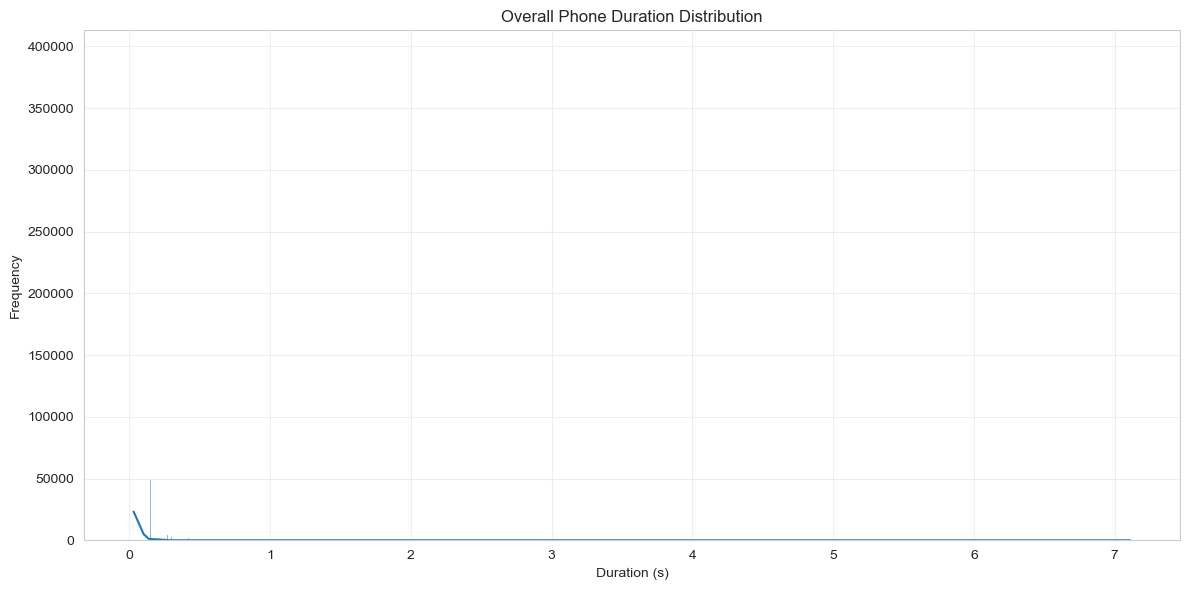

In [13]:
# Plot overall duration distribution
plot_duration_histograms(native_phone_df)

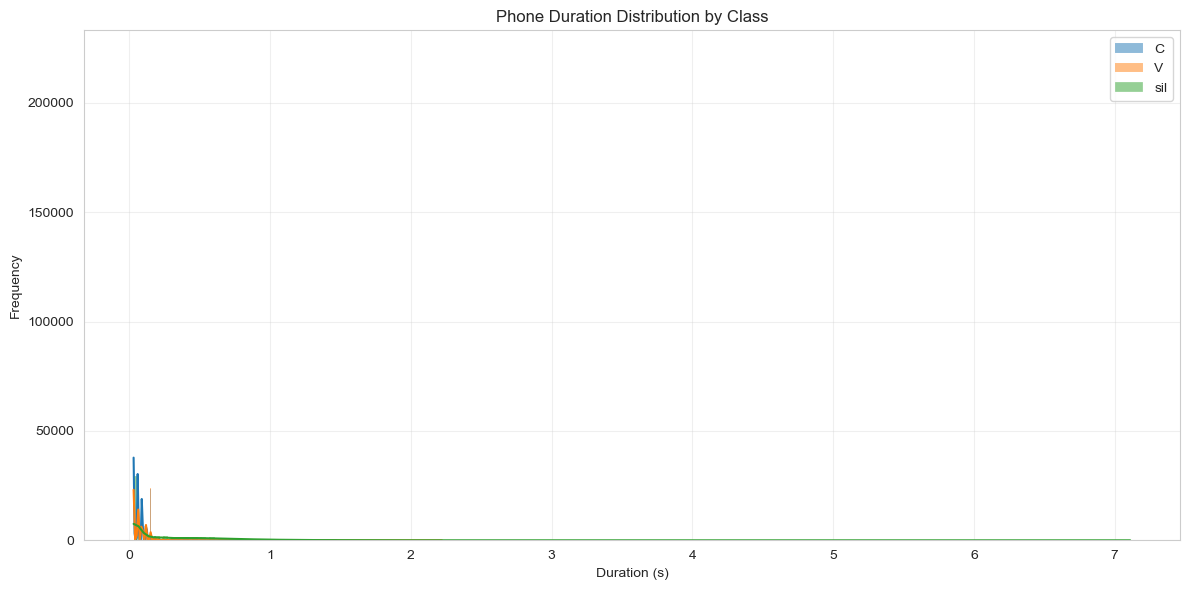

In [14]:
# Plot duration distribution by phone class
plot_duration_histograms(native_phone_df, by_class=True)

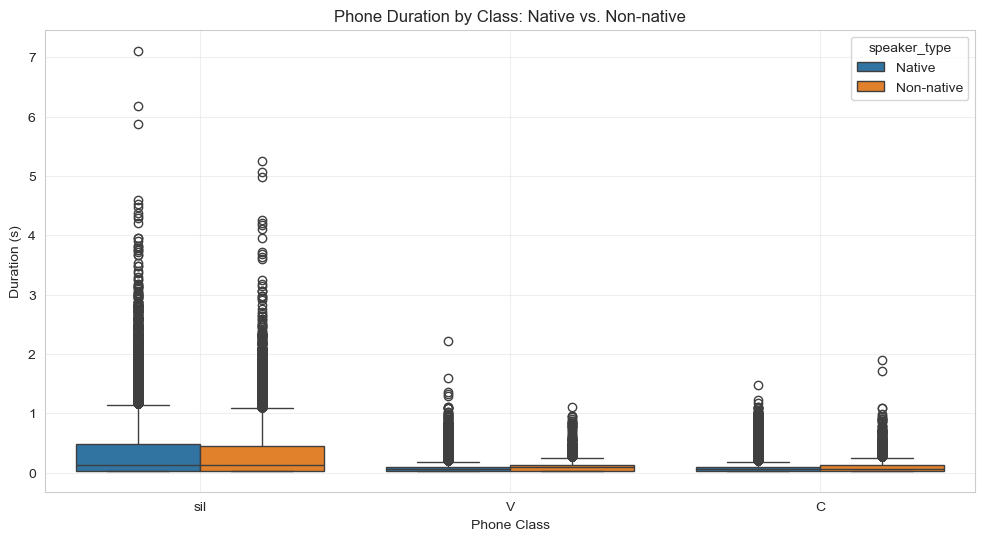

In [15]:
# Compare native and non-native phone durations by class
plt.figure(figsize=(12, 6))

# Add speaker type column
native_phone_df['speaker_type'] = 'Native'
nonnative_phone_df['speaker_type'] = 'Non-native'

# Combine data
combined_df = pd.concat([native_phone_df, nonnative_phone_df])

# Create boxplot
sns.boxplot(x='phone_class', y='phone_duration', hue='speaker_type', data=combined_df)
plt.title('Phone Duration by Class: Native vs. Non-native')
plt.xlabel('Phone Class')
plt.ylabel('Duration (s)')
plt.grid(True, alpha=0.3)
plt.show()

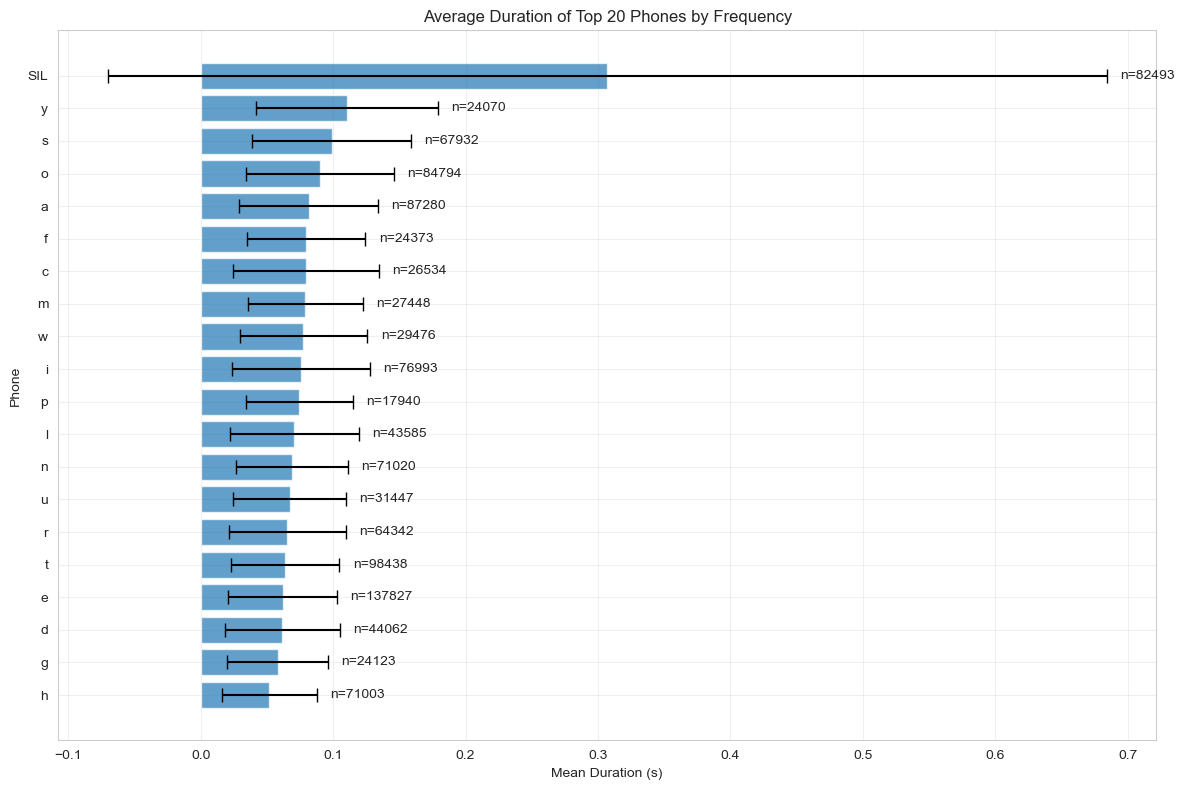

In [16]:
# Plot top phones by duration
plot_top_phones_by_duration(native_phone_df)

## 6. Position Effects

<Figure size 1200x1000 with 0 Axes>

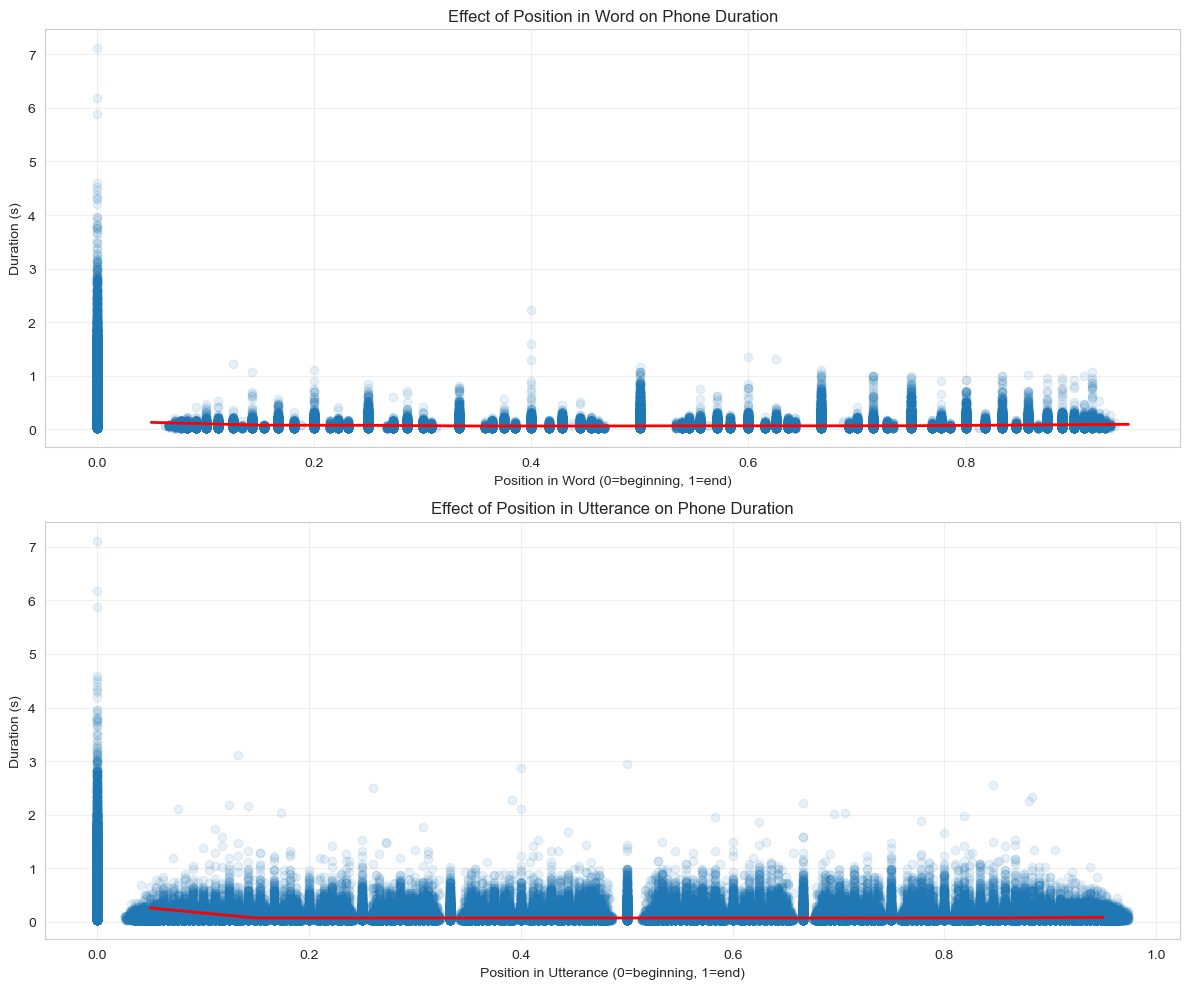

In [17]:
# Plot effects of position on duration
plot_position_effects(native_phone_df)

## 7. Speaking Rate Analysis

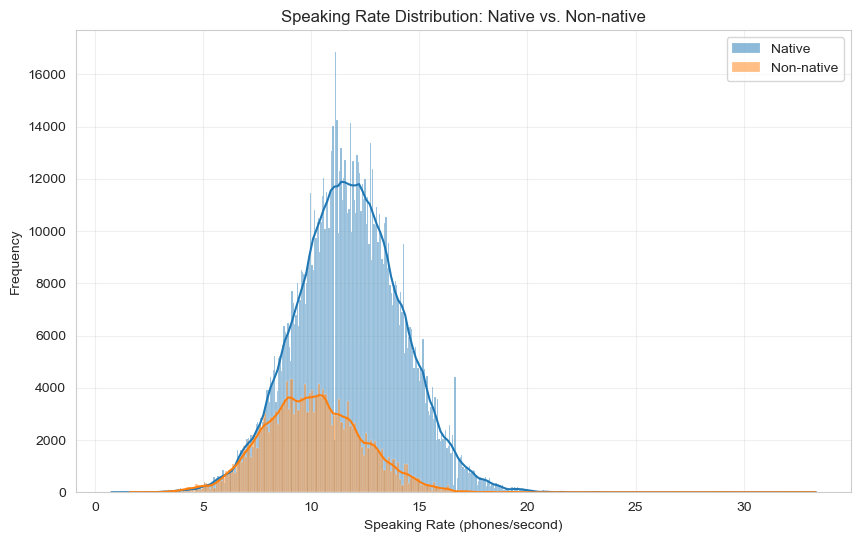

In [18]:
# Plot speaking rate distribution
plt.figure(figsize=(10, 6))
sns.histplot(native_phone_df['speaking_rate'], kde=True, label='Native')
sns.histplot(nonnative_phone_df['speaking_rate'], kde=True, label='Non-native')
plt.title('Speaking Rate Distribution: Native vs. Non-native')
plt.xlabel('Speaking Rate (phones/second)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

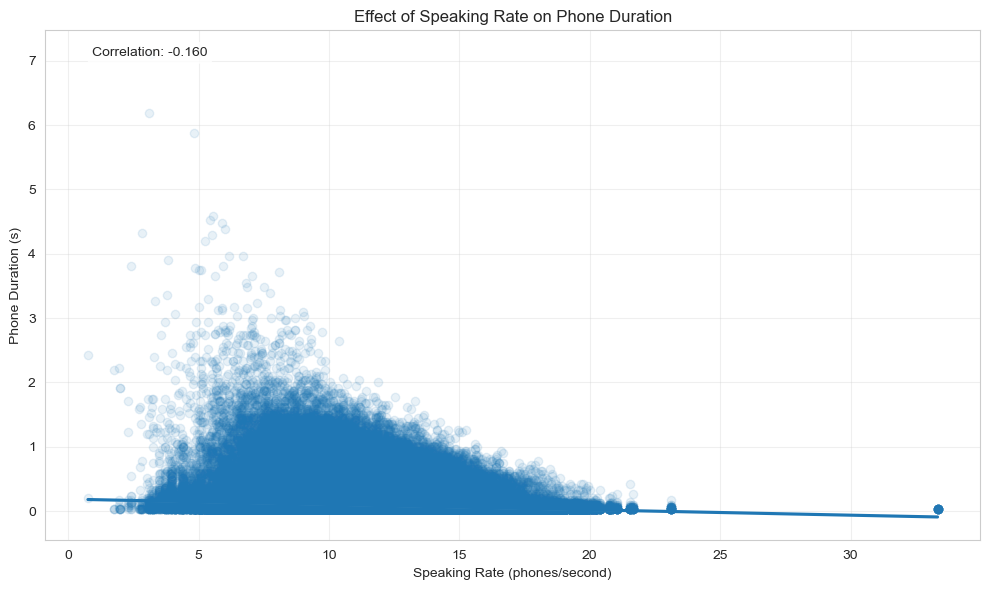

In [19]:
# Plot effect of speaking rate on phone duration
plot_speaking_rate_effects(native_phone_df)

## 8. Context Analysis

In [20]:
# Add context features for analysis
def add_context_features(df, context_size=1):
    """Add context features for each phone."""
    # Sort by utterance and start time
    df = df.sort_values(['utterance_id', 'phone_start']).copy()
    
    # Initialize columns for previous and next phones
    for i in range(1, context_size + 1):
        df[f'prev_{i}_phone'] = 'PAD'
        df[f'next_{i}_phone'] = 'PAD'
    
    # Group by utterance and shift to get previous and next phones
    for i in range(1, context_size + 1):
        df[f'prev_{i}_phone'] = df.groupby('utterance_id')['phone'].shift(i).fillna('PAD')
        df[f'next_{i}_phone'] = df.groupby('utterance_id')['phone'].shift(-i).fillna('PAD')
    
    return df

# Add context features
native_context_df = add_context_features(native_phone_df)
native_context_df.head()

,utterance_id,utterance_text,word,word_idx,word_pos_in_utterance,word_start,word_duration,phone,phone_idx,phone_pos_in_word,phone_start,phone_duration,phone_class,phone_duration_mean,phone_duration_std,speaking_rate,phone_duration_norm,speaker_type,prev_1_phone,next_1_phone
0,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,sil,0,0.000000,0.00,1.14,SIL,0,0.00,0.00,1.14,sil,0.085,0.143095,11.764706,7.372708,Native,PAD,o
1,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,ONCE,1,0.058824,1.14,0.39,o,0,0.00,1.14,0.18,V,0.085,0.143095,11.764706,0.663893,Native,SIL,n
2,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,ONCE,1,0.058824,1.14,0.39,n,1,0.25,1.32,0.09,C,0.085,0.143095,11.764706,0.034942,Native,o,c
3,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,ONCE,1,0.058824,1.14,0.39,c,2,0.50,1.41,0.09,C,0.085,0.143095,11.764706,0.034942,Native,n,e
4,0_0,ONCE THERE WAS A YOUNG RAT NAMED ARTHUR WHO NE...,ONCE,1,0.058824,1.14,0.39,e,3,0.75,1.50,0.03,V,0.085,0.143095,11.764706,-0.384359,Native,c,t


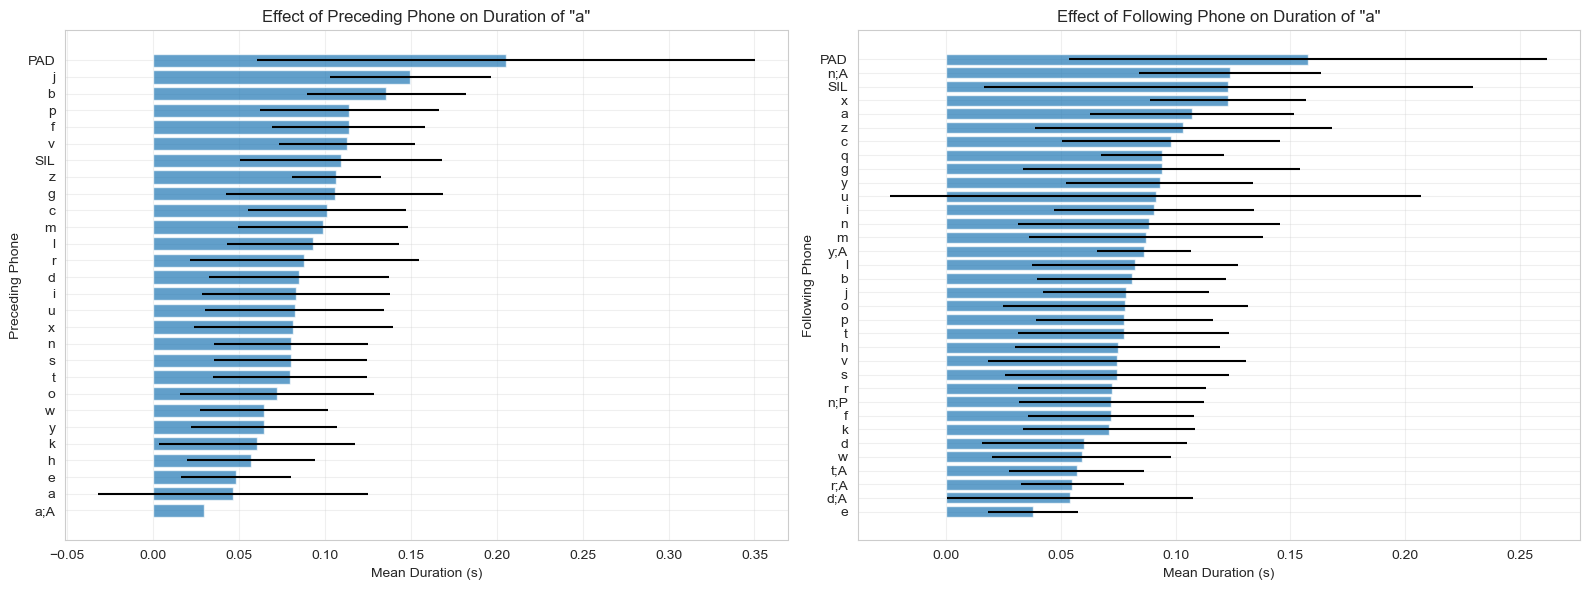

In [21]:
# Analyze effect of preceding and following context on a specific phone
def plot_context_effect(df, target_phone):
    """Plot effect of preceding and following context on a specific phone."""
    # Filter data for the target phone
    phone_data = df[df['phone'] == target_phone]
    
    if len(phone_data) < 10:
        print(f"Not enough data for phone '{target_phone}'")
        return
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Effect of preceding phone
    prev_stats = phone_data.groupby('prev_1_phone')['phone_duration'].agg(['mean', 'std', 'count'])
    prev_stats = prev_stats[prev_stats['count'] >= 5].sort_values('mean')
    
    ax1.barh(prev_stats.index, prev_stats['mean'], xerr=prev_stats['std'], alpha=0.7)
    ax1.set_xlabel('Mean Duration (s)')
    ax1.set_ylabel('Preceding Phone')
    ax1.set_title(f'Effect of Preceding Phone on Duration of "{target_phone}"')
    ax1.grid(True, alpha=0.3)
    
    # 2. Effect of following phone
    next_stats = phone_data.groupby('next_1_phone')['phone_duration'].agg(['mean', 'std', 'count'])
    next_stats = next_stats[next_stats['count'] >= 5].sort_values('mean')
    
    ax2.barh(next_stats.index, next_stats['mean'], xerr=next_stats['std'], alpha=0.7)
    ax2.set_xlabel('Mean Duration (s)')
    ax2.set_ylabel('Following Phone')
    ax2.set_title(f'Effect of Following Phone on Duration of "{target_phone}"')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Analyze context effects for a common vowel
plot_context_effect(native_context_df, 'a')

## 9. Native vs. Non-native Comparison

In [22]:
# Compare phone durations between native and non-native speakers
def compare_phone_durations(native_df, nonnative_df, min_samples=20):
    """Compare phone durations between native and non-native speakers."""
    # Calculate mean duration for each phone
    native_stats = native_df.groupby('phone')['phone_duration'].agg(['mean', 'std', 'count']).reset_index()
    nonnative_stats = nonnative_df.groupby('phone')['phone_duration'].agg(['mean', 'std', 'count']).reset_index()
    
    # Merge the stats
    stats = pd.merge(native_stats, nonnative_stats, on='phone', suffixes=('_native', '_nonnative'))
    
    # Filter for phones with sufficient samples in both groups
    stats = stats[(stats['count_native'] >= min_samples) & (stats['count_nonnative'] >= min_samples)]
    
    # Calculate relative difference
    stats['diff'] = stats['mean_nonnative'] - stats['mean_native']
    stats['diff_pct'] = (stats['diff'] / stats['mean_native']) * 100
    
    # Sort by absolute percentage difference
    stats = stats.sort_values('diff_pct', key=abs, ascending=False)
    
    return stats

# Compare phone durations
comparison = compare_phone_durations(native_phone_df, nonnative_phone_df)
comparison.head(10)

,phone,mean_native,std_native,count_native,mean_nonnative,std_nonnative,count_nonnative,diff,diff_pct
1,G01,0.314605,0.142689,152,0.200294,0.127115,68,-0.114311,-36.334785
14,e;A,0.056544,0.032871,651,0.072812,0.045392,96,0.016269,28.771903
47,t,0.063863,0.040955,98438,0.077651,0.047689,16486,0.013789,21.590809
55,w,0.077629,0.048310,29476,0.091950,0.050173,5124,0.014321,18.447675
16,f,0.079621,0.044767,24373,0.094247,0.048907,4026,0.014626,18.369569
35,n;A,0.051264,0.030014,910,0.060559,0.038459,161,0.009295,18.132252
34,n,0.069038,0.042059,71020,0.081358,0.049191,11764,0.012319,17.843815
45,s,0.098816,0.059866,67932,0.114572,0.066486,11247,0.015755,15.944127
6,b,0.066680,0.039213,15741,0.077090,0.042359,2505,0.010410,15.611595
23,i;A,0.074157,0.043027,801,0.085618,0.047767,89,0.011461,15.454545


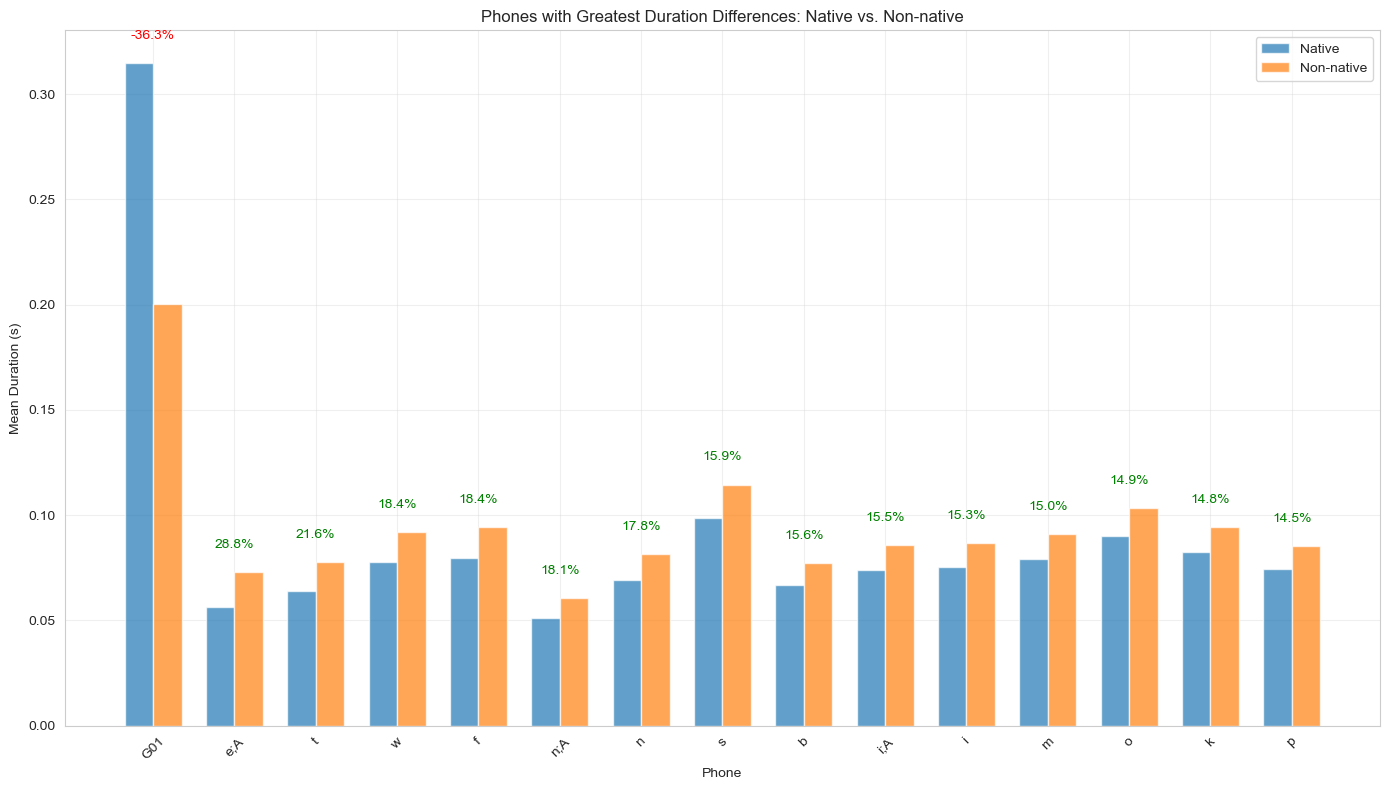

In [23]:
# Plot top differences
top_diff = comparison.head(15)

plt.figure(figsize=(14, 8))

# Create bars
x = np.arange(len(top_diff))
width = 0.35

plt.bar(x - width/2, top_diff['mean_native'], width, label='Native', alpha=0.7)
plt.bar(x + width/2, top_diff['mean_nonnative'], width, label='Non-native', alpha=0.7)

# Add labels and title
plt.xticks(x, top_diff['phone'], rotation=45)
plt.xlabel('Phone')
plt.ylabel('Mean Duration (s)')
plt.title('Phones with Greatest Duration Differences: Native vs. Non-native')
plt.legend()
plt.grid(True, alpha=0.3)

# Add percentage difference annotations
for i, row in enumerate(top_diff.itertuples()):
    plt.text(i, max(row.mean_native, row.mean_nonnative) + 0.01,
             f"{row.diff_pct:.1f}%",
             ha='center', va='bottom',
             color='green' if row.diff_pct > 0 else 'red')

plt.tight_layout()
plt.show()

## 10. Summary Statistics for Modeling

In [25]:
# Calculate summary statistics for each phone
def calculate_phone_stats(df):
    """Calculate statistics for each phone."""
    phone_stats = df.groupby('phone').agg({
        'phone_duration': ['count', 'mean', 'std', 'min', 'max']
    })
    
    phone_stats.columns = ['_'.join(col).strip() for col in phone_stats.columns.values]
    phone_stats = phone_stats.reset_index()
    
    # Replace NaN std with 0
    phone_stats['phone_duration_std'] = phone_stats['phone_duration_std'].fillna(0)

    
    return phone_stats

# Calculate statistics for native speakers
native_phone_stats = calculate_phone_stats(native_phone_df)
native_phone_stats.sort_values('phone_duration_count', ascending=False).head(20)

,phone,phone_duration_count,phone_duration_mean,phone_duration_std,phone_duration_min,phone_duration_max
14,e,137827,0.061791,0.040814,0.03,0.99
52,t,98438,0.063863,0.040955,0.03,0.99
3,a,87280,0.081638,0.052536,0.03,2.22
40,o,84794,0.090084,0.056178,0.03,1.08
2,SIL,82493,0.306984,0.377113,0.03,7.11
25,i,76993,0.075410,0.052087,0.03,1.32
37,n,71020,0.069038,0.042059,0.03,0.90
22,h,71003,0.051758,0.035916,0.03,1.08
49,s,67932,0.098816,0.059866,0.03,1.47
46,r,64342,0.065423,0.044019,0.03,0.99


<Figure size 1400x600 with 0 Axes>

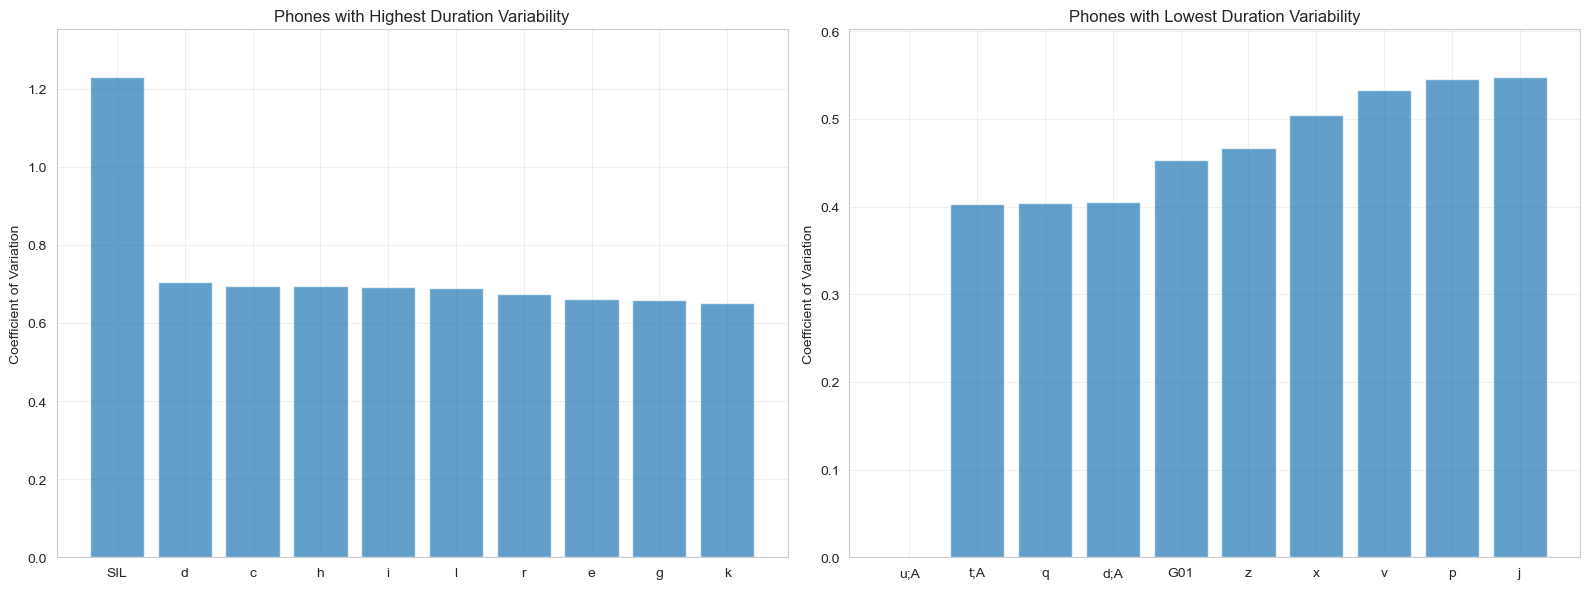

In [26]:
# Analyze variability in duration
# Calculate coefficient of variation (CV = std/mean)
native_phone_stats['cv'] = native_phone_stats['phone_duration_std'] / native_phone_stats['phone_duration_mean']

# Plot phones with highest and lowest variability
plt.figure(figsize=(14, 6))

# Filter for phones with sufficient samples
filtered_stats = native_phone_stats[native_phone_stats['phone_duration_count'] >= 50]

# Top 10 most variable phones
top_variable = filtered_stats.sort_values('cv', ascending=False).head(10)
# Top 10 least variable phones
top_consistent = filtered_stats.sort_values('cv').head(10)

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Most variable phones
ax1.bar(top_variable['phone'], top_variable['cv'], alpha=0.7)
ax1.set_ylabel('Coefficient of Variation')
ax1.set_title('Phones with Highest Duration Variability')
ax1.set_ylim(0, max(top_variable['cv']) * 1.1)
ax1.grid(True, alpha=0.3)

# Least variable phones
ax2.bar(top_consistent['phone'], top_consistent['cv'], alpha=0.7)
ax2.set_ylabel('Coefficient of Variation')
ax2.set_title('Phones with Lowest Duration Variability')
ax2.set_ylim(0, max(top_consistent['cv']) * 1.1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Conclusions and Next Steps

### Key Findings:

1. **Phone Duration Distribution**: We observed significant variation in phone durations, with some phones consistently longer or shorter than others.

2. **Phone Class Effects**: Vowels generally have longer durations than consonants, with silence segments showing the highest variability.

3. **Position Effects**: Phone position within words and utterances impacts duration. We observed:
   - Phones at word boundaries tend to be longer
   - Utterance-final lengthening is evident

4. **Context Effects**: The identity of surrounding phones significantly influences duration, suggesting coarticulation effects.

5. **Speaking Rate**: There's a strong inverse relationship between speaking rate and phone duration.

6. **Native vs. Non-native Differences**: Non-native speakers show systematic differences in phone durations compared to native speakers, with certain phones consistently longer or shorter.

### Next Steps for Modeling:

1. **Feature Engineering**: Incorporate the findings into features for duration prediction models:
   - Phone identity
   - Phone class
   - Context (preceding and following phones)
   - Position features
   - Speaking rate

2. **Model Selection**: Start with a baseline statistical model, then explore more sophisticated approaches:
   - Baseline: Mean and variance per phone
   - Linear regression
   - Tree-based models (Random Forest, XGBoost)
   - Neural networks (LSTM)

3. **Evaluation**: Set up proper evaluation metrics to compare model performance:
   - MAE (Mean Absolute Error)
   - RMSE (Root Mean Square Error)
   - Correlation between predicted and actual durations

4. **Analysis**: Analyze model performance by phone class, position, and other factors to identify areas for improvement.